In [10]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
import sys

from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp
from scipy.stats import ttest_rel

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('poster',font_scale=1)

In [12]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,AUC = True,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        
        
        #Round predicted values for Regression model
#         if model_name == 'Random Forest Regressor':
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        if AUC:
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    fpr, tpr, thresh = roc_curve(yt,ys)
                    tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                    tprs.append(tpr)

                tpr = sum(tprs)
                fpr = fpr_mean
                
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])

            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
                
            RMS_all.append(auroc)
            
        else:

            RMS=0
            for yp,yt in zip(ypred,y):
                RMS += ((yp - yt)**2)
            RMS = RMS / len(y)
            RMS = math.sqrt(RMS)

            RMS_all.append(RMS)

        groupres[model_name] = {'RMS':RMS_all, 'tpr': tpr_all, 'fpr':fpr_all}

        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [13]:
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

featdict_full = {'freq':['Dom_freqX','Pdom_relX','PSD_meanX','PSD_stdX','PSD_skewX','PSD_kurX',
                        'Dom_freqY','Pdom_relY','PSD_meanY','PSD_stdY','PSD_skewY','PSD_kurY',
                        'Dom_freqZ','Pdom_relZ','PSD_meanZ','PSD_stdZ','PSD_skewZ','PSD_kurZ',
                        'Dom_freq_mag','Pdom_rel_mag','PSD_mean_mag','PSD_std_mag','PSD_skew_mag','PSD_kur_mag'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                   'RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag'],
            'entropy':['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_meanX','jerk_stdX','jerk_skewX','jerk_kurX',
                    'jerk_meanY','jerk_stdY','jerk_skewY','jerk_kurY',
                    'jerk_meanZ','jerk_stdZ','jerk_skewZ','jerk_kurZ',
                    'jerk_mean_mag','jerk_std_mag','jerk_skew_mag','jerk_kur_mag']}

featdict_tri = {'freq':['Dom_freqX','Pdom_relX','PSD_meanX','PSD_stdX','PSD_skewX','PSD_kurX',
                        'Dom_freqY','Pdom_relY','PSD_meanY','PSD_stdY','PSD_skewY','PSD_kurY',
                        'Dom_freqZ','Pdom_relZ','PSD_meanZ','PSD_stdZ','PSD_skewZ','PSD_kurZ'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ'],
            'entropy':['Sen_X', 'Sen_Y', 'Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_meanX','jerk_stdX','jerk_skewX','jerk_kurX',
                    'jerk_meanY','jerk_stdY','jerk_skewY','jerk_kurY',
                    'jerk_meanZ','jerk_stdZ','jerk_skewZ','jerk_kurZ']}

featdict_mag = {'freq':['Dom_freq_mag','Pdom_rel_mag','PSD_mean_mag','PSD_std_mag','PSD_skew_mag','PSD_kur_mag'],
            'time':['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag'],
            'entropy':['Sen_mag'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean_mag','jerk_std_mag','jerk_skew_mag','jerk_kur_mag']}

#Accel+Gyro file has features labeled with 'acc' and 'gyr' 
def fix_feature_names(features):
    feats = features.copy()
    if feats[0][-3:] != 'acc':
        featlen = len(feats)
        for f in range(featlen):
            feats.append(feats[f] + ' gyr')
        for f in range(featlen):
            feats[f] = feats[f] + ' acc'
    return feats

In [15]:
datadict = {'watch':{'Tremor':{},'Bradykinesia':{}},'sensor':{'Tremor':{},'Bradykinesia':{}}}
datadict['watch']['Tremor']['Binary'] = pd.read_csv('Watch Data 30Hz.csv',index_col=0)
datadict['watch']['Bradykinesia']['Binary'] = pd.read_csv('Watch Data 30Hz.csv',index_col=0)
datadict['sensor']['Tremor']['Binary'] = pd.read_csv('Accel Data 30Hz.csv',index_col=0)
datadict['sensor']['Bradykinesia']['Binary'] = pd.read_csv('Accel+Gyro Data 30Hz.csv',index_col=0)
datadict['watch']['Tremor']['Multiclass'] = pd.read_csv('Watch Data 30Hz.csv',index_col=0)
datadict['watch']['Bradykinesia']['Multiclass'] = pd.read_csv('Watch Data 30Hz.csv',index_col=0)
datadict['sensor']['Tremor']['Multiclass'] = pd.read_csv('Accel Data 30Hz.csv',index_col=0)
datadict['sensor']['Bradykinesia']['Multiclass'] = pd.read_csv('Accel+Gyro Data 30Hz.csv',index_col=0)

In [17]:
#skip this cell and open pkl file

t1 = time.time()
results = {}
for featdict, filename in zip([featdict_full, featdict_tri, featdict_mag],['full', 'tri', 'mag']):
    
    featdictsensors = {}
    for featgroup in featdict.keys():
        feats = fix_feature_names(featdict[featgroup])
        featdictsensors[featgroup] = feats
    
    lst = featdict.keys()
    combs = []
    for i in range(len(lst)):
        els = [list(x) for x in combinations(lst, i+1)]
        combs.extend(els)
        
    for mode in ['watch','sensor']:

        results[mode] = {}

        for symptom in ['Tremor','Bradykinesia']:

            count = 0
            print(mode + ', ' + symptom)

            results[mode][symptom] = {}

            dataBin = datadict[mode][symptom]['Binary']
            dataMulti = datadict[mode][symptom]['Multiclass']

            results[mode][symptom]['Binary'] = {}
            binary_res_all = pd.DataFrame()
            binary_res_groups = {}

            results[mode][symptom]['Multiclass'] = {}
            multi_res_all = pd.DataFrame()
            multi_res_groups = {}

            for comb in combs:

                count += 1
                print('Combination %d of %d'%(count,len(combs)))

                feat_cols = []
                comb_group = ''

                for features_set in comb:

                    comb_group += features_set[0]
                    if mode == 'sensor' and symptom == 'Bradykinesia':
                        feat_cols = feat_cols + featdictsensors[features_set]
                    else:
                        feat_cols = feat_cols + featdict[features_set]

                DataBin = dataBin[info + feat_cols].copy()
                DataMulti = dataMulti[info + feat_cols].copy()

                DataBin=DataBin[~DataBin[symptom].isnull()] #remove nan rows for current symptom
                for s in DataBin.columns.values[5:]:
                    DataBin.loc[DataBin[s]>np.finfo(np.float32).max,s] = 100
                DataBin=DataBin.reset_index(drop=True) #reset index
                DataMulti=DataMulti[~DataMulti[symptom].isnull()] #remove nan rows for current symptom
                for s in DataMulti.columns.values[5:]:
                    DataMulti.loc[DataMulti[s]>np.finfo(np.float32).max,s] = 100
                DataMulti=DataMulti.reset_index(drop=True) #reset index

                #Binary

                X = DataBin.iloc[:,5:].values
                groups = DataBin.Subject.values
                fnames = DataBin.iloc[:,5:].columns.values

                y = ((DataBin[symptom]>0)).values.astype(int)

                model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
                model_name = ['Random Forest']
                model = list(zip(model,model_name))

                res,res_group = LOSOCV(DataBin,X,y,groups,model)
                res['Combination'] = comb_group
                binary_res_all = pd.concat((binary_res_all,res))
                binary_res_groups[comb_group] = res_group

                #Multiple Classes

                X = DataMulti.iloc[:,5:].values
                groups = DataMulti.Subject.values
                fnames = DataMulti.iloc[:,5:].columns.values

                y = DataMulti[symptom].values.astype(int)

                model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
                model_name = ['Random Forest']
                model = list(zip(model,model_name))

                res,res_group = LOSOMultiClass(DataMulti,X,y,groups,model,True)
                res['Combination'] = comb_group
                multi_res_groups[comb_group] = res_group
                R = pd.DataFrame()
                R['RMS'] = [np.nanmean(multi_res_groups[comb_group][model_name[0]]['RMS'])]
                R['Model'] = ['Random Forest']
                R['Combination'] = [comb_group]
                multi_res_all = pd.concat([multi_res_all,R])

            results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
            results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

            results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
            results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

    f = open('FeaturesAnalysisResults_'+filename+'.pkl','wb')
    pickle.dump(results,f)
    f.close()

    print('Elapsed time = %.3f min'%((time.time()-t1)/60))

watch, Tremor
Combination 1 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
watch, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Trainin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 31 of 31
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
sensor, Bradykinesia
Combination 1 of 31
Training Random Forest
Training Random Forest
Combination 2 of 31
Training Random Forest
Training Random Forest
Combination 3 of 31
Training Random Forest
Training Random Forest
Combination 4 of 31
Training Random Forest
Training Random Forest
Combination 5 of 31
Training Random Forest
Training Random Forest
Combination 6 of 31
Training Random Forest
Training Random Forest
Combination 7 of 31
Training Random Forest
Training Random Forest
Combination 8 of 31
Training Random Forest
Training Random Forest
Combination 9 of 31
Training Random Forest
Training Random Forest
Combination 10 of 31
Training Random Forest
Training Random Forest
Combination 11 of 31
Training Random Forest
Training Random Forest
Combination 12 of 31
Training Random Forest
Training Random Forest
Combination 13 of 31
Training Random Forest
Training Random Forest
Combination 14 of 31
Training Random Forest
Training Random Forest
Combination 15 of 31
Traini

In [295]:
f = open('FeaturesAnalysisResults_full.pkl','rb')
full_results = pickle.load(f)
f.close()

In [296]:
T = [0.00101043, 0.00232074, 0.0034716,  0.04128475, 0.0010748,  0.0089197,
 0.00242512, 0.00134522, 0.01359604, 0.00302631, 0.00071365]
TDict = {'t': T[2]+T[7], 'e': T[3]+T[8], 'c': T[4], 'f': T[5]+T[9], 'j': T[6]+T[10]}

In [297]:
D = pd.concat([full_results['sensor']['Tremor']['Binary']['res_all'].auroc,
           full_results['sensor']['Tremor']['Multiclass']['res_all'].RMS,
           full_results['sensor']['Bradykinesia']['Binary']['res_all'].auroc,
           full_results['sensor']['Bradykinesia']['Multiclass']['res_all'].RMS],axis=1)
D.index = [c for c in full_results['sensor']['Tremor']['Binary']['res_all'].Combination]
D['Times'] = [sum([TDict[f] for f in g])+T[0]+T[1] for g in D.index]
D.sort_values(by='Times',inplace=True)

In [298]:
print(D)

          auroc       RMS     auroc       RMS     Times
c      0.683654  0.668824  0.613911  0.594211  0.004406
j      0.725163  0.711995  0.641022  0.619481  0.006470
cj     0.722486  0.704650  0.652407  0.623601  0.007545
t      0.731763  0.698029  0.673269  0.639273  0.008148
tc     0.727632  0.698302  0.662234  0.639132  0.009223
tj     0.742871  0.718420  0.680417  0.651082  0.011287
tcj    0.738967  0.717270  0.670996  0.643608  0.012362
f      0.740311  0.725564  0.668794  0.647886  0.015277
fc     0.738999  0.733948  0.660488  0.635488  0.016352
fj     0.745250  0.741753  0.670677  0.644869  0.018416
fcj    0.737267  0.727381  0.663324  0.628261  0.019491
ft     0.754462  0.738454  0.672234  0.642015  0.020094
ftc    0.746361  0.727819  0.667138  0.645273  0.021169
ftj    0.751791  0.738930  0.677283  0.644032  0.023233
ftcj   0.760314  0.731717  0.675468  0.643995  0.024308
e      0.619769  0.611519  0.590401  0.559498  0.058212
ec     0.765896  0.733013  0.648787  0.612550  0

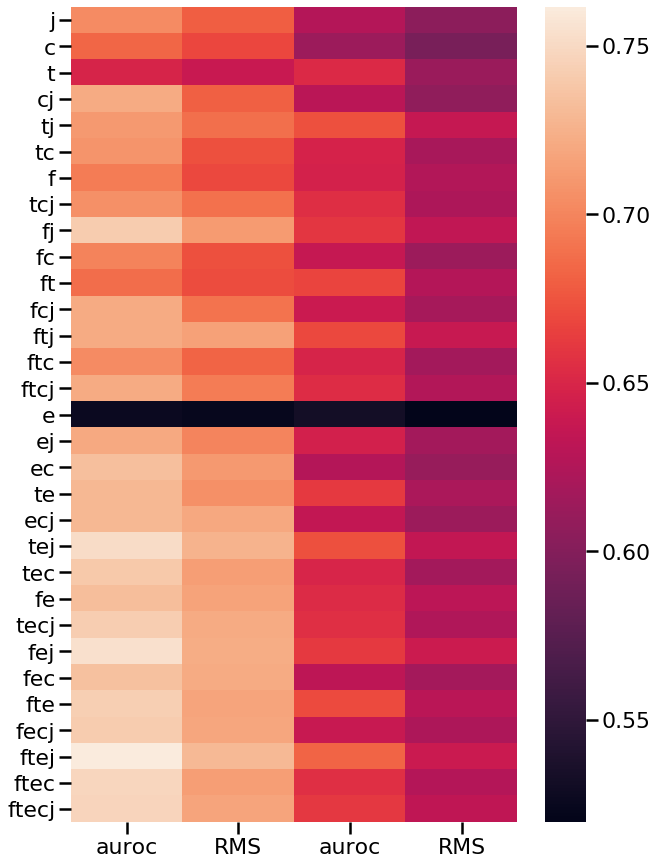

In [48]:
plt.figure(figsize=(10,15))
sns.heatmap(D.drop(columns=['Times']))

In [299]:
entropyComps = list(zip(['c', 'j', 'cj', 't', 'tc', 'tj', 'tcj', 'f', 'fc', 'fj', 'fcj', 'ft', 'ftc', 'ftj', 'ftcj'],
                        ['ec', 'ej', 'ecj', 'te', 'tec', 'tej', 'tecj', 'fe', 'fec', 'fej', 'fecj', 'fte', 'ftec', 'ftej', 'ftecj']))

In [300]:
diffs = []
for pair in entropyComps:
    print(PairedT(full_results['sensor']['Tremor']['Binary']['res_groups'][pair[0]]['Random Forest']['auroc'],
                  full_results['sensor']['Tremor']['Binary']['res_groups'][pair[1]]['Random Forest']['auroc']))
    diffs.append(np.subtract(full_results['sensor']['Tremor']['Binary']['res_groups'][pair[1]]['Random Forest']['auroc'],
                            full_results['sensor']['Tremor']['Binary']['res_groups'][pair[0]]['Random Forest']['auroc']))
print(np.nanmean(diffs),stats.sem(diffs,nan_policy='omit'))

Ttest_relResult(statistic=-4.62696430941652, pvalue=0.0007320178934943556)
Ttest_relResult(statistic=-3.9434704871261634, pvalue=0.002298301333388055)
Ttest_relResult(statistic=-2.2902271027742693, pvalue=0.042760603310905664)
Ttest_relResult(statistic=-2.1740276919467303, pvalue=0.05240798005219412)
Ttest_relResult(statistic=-3.8876510620157676, pvalue=0.002529797238457296)
Ttest_relResult(statistic=-1.7213743896414817, pvalue=0.11314782499546776)
Ttest_relResult(statistic=-2.828307077323619, pvalue=0.016421813121867256)
Ttest_relResult(statistic=-2.7414990216291746, pvalue=0.01917997316513399)
Ttest_relResult(statistic=-2.666766469195459, pvalue=0.021920227446526344)
Ttest_relResult(statistic=-1.7269490467736561, pvalue=0.11211275398723813)
Ttest_relResult(statistic=-1.9246166120124744, pvalue=0.08051933907837476)
Ttest_relResult(statistic=-1.7684487554746078, pvalue=0.10467134277328417)
Ttest_relResult(statistic=-3.1631991009723675, pvalue=0.009027333335571357)
Ttest_relResult(stati

In [301]:
diffs

[array([ 0.1654476 ,  0.05263388, -0.00647969,  0.00096525,  0.09031058,
         0.05775529,  0.12695952,  0.08548014,  0.05389977,         nan,
         0.07489474,  0.07684298,  0.20819842]),
 array([ 0.00687726,  0.02408202,  0.01290933,  0.008958  ,  0.04138351,
         0.03667732,  0.06365477,  0.02125688,  0.00754481,         nan,
         0.03898011,  0.01890676, -0.0099728 ]),
 array([0.02805785, 0.02248694, 0.0039644 , 0.00577973, 0.03238543,
        0.0131141 , 0.00130426, 0.03532323, 0.00456551,        nan,
        0.03472924, 0.00770467, 0.16565212]),
 array([ 0.01521156,  0.03103396, -0.01411317, -0.00088874,  0.03722308,
         0.04386455,  0.09529048,  0.04923008,  0.0100296 ,         nan,
         0.04203265,  0.02257719, -0.05342572]),
 array([ 0.04605238,  0.02063051, -0.01146022, -0.01482602,  0.04383178,
         0.06498469,  0.06239635,  0.04221199,  0.00284758,         nan,
         0.04548841,  0.01756471,  0.04345292]),
 array([-0.00617788,  0.02958564, -0.0

In [302]:
PairedT(results['sensor']['Tremor']['Multiclass']['res_groups']['ftej']['Random Forest']['RMS'],
        full_results['sensor']['Tremor']['Multiclass']['res_groups']['fec']['Random Forest']['RMS'])

Ttest_relResult(statistic=-1.7374615372284943, pvalue=0.11018398360521357)

In [303]:
full_dict = {}
full_sem = {}
TB = D.iloc[:,[0,4]]; diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_sem['TB'] = np.mean(stats.sem([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                    for g in TB.index],nan_policy='omit'))

while not all(diff):
    TB = TB[diff]
    diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['TB']=[full_results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in TB.index]
print(TB.index)
TB.columns = ['AUROC','Computation Time']

TM = D.iloc[:,[1,4]]; diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_sem['TM'] = np.mean(stats.sem([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                    for g in TM.index],nan_policy='omit'))

while not all(diff):
    TM = TM[diff]
    diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['TM']=[full_results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in TM.index]
print(TM.index)
TM.columns = ['AUROC','Computation Time']


BB = D.iloc[:,[2,4]]; diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_sem['BB'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                    for g in TB.index],nan_policy='omit'))

while not all(diff):
    BB = BB[diff]
    diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['BB']=[full_results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in BB.index]
print(BB.index)
BB.columns = ['AUROC','Computation Time']


BM = D.iloc[:,[3,4]]; diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_sem['BM'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                    for g in TM.index],nan_policy='omit'))

while not all(diff):
    BM = BM[diff]
    diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
full_dict['BM']=[full_results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in BM.index]
print(BM.index)
BM.columns = ['AUROC','Computation Time']


Index(['c', 'j', 't', 'tj', 'fj', 'ft', 'ftcj', 'ec', 'fe', 'fte', 'ftec'], dtype='object')
Index(['c', 'j', 'tj', 'f', 'fc', 'fj', 'fe', 'fej', 'ftec'], dtype='object')
Index(['c', 'j', 'cj', 't', 'tj', 'te', 'tej'], dtype='object')
Index(['c', 'j', 'cj', 't', 'tj', 'fte', 'ftej'], dtype='object')


In [58]:
groups = full_results['sensor']['Tremor']['Binary']['res_all']['Combination'].values

In [304]:
D = pd.DataFrame(data = np.vstack([full_results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in TB.index]).transpose(), 
                 columns = TB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(6.620697628075646, 5.7007360570953084e-08)

In [305]:
D

,c,j,t,tj,fj,ft,ftcj,ec,fe,fte,ftec
0,0.549510,0.650979,0.722923,0.707503,0.635209,0.658473,0.670081,0.714958,0.730024,0.729888,0.732200
1,0.691517,0.678362,0.689193,0.677935,0.704939,0.699958,0.705873,0.744151,0.741549,0.731475,0.725451
2,0.800624,0.800696,0.829946,0.830685,0.832887,0.827386,0.834674,0.794144,0.806005,0.827661,0.834138
3,0.791423,0.743955,0.784478,0.756910,0.752919,0.804731,0.778245,0.792389,0.774714,0.785985,0.781382
4,0.609632,0.654046,0.669948,0.702482,0.697931,0.689864,0.718934,0.699942,0.717737,0.716262,0.712802
5,0.647901,0.669820,0.653854,0.711169,0.729990,0.706400,0.738124,0.705656,0.736576,0.726710,0.729749
6,0.809073,0.856493,0.825366,0.924890,0.938766,0.914298,0.932732,0.936033,0.925619,0.916590,0.919998
7,0.834963,0.899337,0.868105,0.910869,0.921137,0.908226,0.927918,0.920443,0.905053,0.902574,0.916167
8,0.766263,0.835780,0.758109,0.839804,0.871975,0.856508,0.865916,0.820163,0.865568,0.854831,0.866185
10,0.312056,0.262175,0.224503,0.264184,0.261350,0.246420,0.261009,0.386951,0.356411,0.300130,0.296130


In [306]:
HBCorrections(D,[('ftec','c'),('ftec','j'),('ftec','t'),('ftec','tj'),('ftec','fj'),('ftec','ft'),('ftec','ftcj'),('ftec','ec'),
                 ('ftec','fe'),('ftec','fte')])

ftec+j       0.000	0.005	Reject
ftec+c       0.000	0.006	Reject
ftec+t       0.001	0.006	Reject
ftec+ft      0.004	0.007	Reject
ftec+tj      0.018	0.008	Accept
ftec+fj      0.022	0.010	Accept
ftec+ftcj    0.040	0.013	Accept
ftec+fte     0.071	0.017	Accept
ftec+ec      0.126	0.025	Accept
ftec+fe      0.155	0.050	Accept


In [307]:
TB

,AUROC,Computation Time
c,0.683654,0.004406
j,0.725163,0.006470
t,0.731763,0.008148
tj,0.742871,0.011287
fj,0.745250,0.018416
ft,0.754462,0.020094
ftcj,0.760314,0.024308
ec,0.765896,0.059287
fe,0.768988,0.070158
fte,0.769285,0.074975


In [308]:
D = pd.DataFrame(data = np.vstack([full_results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in TM.index]).transpose(), 
                 columns = TM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(8.904424424822869, 7.337839703681372e-09)

In [309]:
D

,c,j,tj,f,fc,fj,fe,fej,ftec
0,0.545462,0.666790,0.697349,0.637393,0.635378,0.665502,0.725986,0.715907,0.713937
1,0.695895,0.698249,0.666633,0.711829,0.718915,0.702087,0.742939,0.727336,0.721577
2,0.819522,0.802634,0.828085,0.809996,0.823113,0.834283,0.808720,0.822829,0.826235
3,0.789174,0.746705,0.761852,0.804811,0.785426,0.751991,0.761286,0.762042,0.774893
4,0.612363,0.626638,0.693900,0.675335,0.672087,0.679283,0.706841,0.701394,0.708918
5,0.624633,0.637381,0.679957,0.691352,0.695843,0.707083,0.720016,0.714807,0.706003
6,0.809174,0.851096,0.923439,0.903064,0.904287,0.930413,0.927379,0.933752,0.919884
7,0.841304,0.886525,0.882337,0.887184,0.899090,0.916869,0.909937,0.924507,0.904696
8,0.664922,0.730916,0.708226,0.777658,0.785486,0.786233,0.779283,0.778357,0.761547
10,0.341641,0.318826,0.307390,0.317174,0.321331,0.333022,0.417671,0.353105,0.352866


In [310]:
HBCorrections(D,[('ftec','c'),('ftec','j'),('ftec','tj'),('ftec','f'),('ftec','fc'),('ftec','fj'),('ftec','fe'),
                 ('ftec','fej')])

ftec+j       0.000	0.006	Reject
ftec+c       0.001	0.007	Reject
ftec+tj      0.001	0.008	Reject
ftec+f       0.014	0.010	Accept
ftec+fc      0.015	0.013	Accept
ftec+fj      0.037	0.017	Accept
ftec+fej     0.226	0.025	Accept
ftec+fe      0.234	0.050	Accept


In [311]:
TM

,AUROC,Computation Time
c,0.668824,0.004406
j,0.711995,0.006470
tj,0.718420,0.011287
f,0.725564,0.015277
fc,0.733948,0.016352
fj,0.741753,0.018416
fe,0.753445,0.070158
fej,0.753671,0.073297
ftec,0.754444,0.076050


In [312]:
D = pd.DataFrame(data = np.vstack([full_results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in BB.index]).transpose(), 
                 columns = BB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(7.230594340151145, 4.602295338945629e-06)

In [313]:
D

,c,j,cj,t,tj,te,tej
0,0.628107,0.592501,0.632736,0.695557,0.713360,0.709143,0.713383
1,0.765038,0.784867,0.796368,0.811152,0.805991,0.797022,0.778689
2,0.820013,0.785079,0.775708,0.807346,0.795525,0.818427,0.786376
3,0.516685,0.659453,0.626915,0.603312,0.605141,0.598137,0.605079
4,0.743014,0.765937,0.779632,0.789314,0.784439,0.786909,0.804237
5,0.663648,0.673389,0.677190,0.650107,0.676585,0.655294,0.649920
6,0.594276,0.662769,0.672376,0.797289,0.781204,0.800539,0.792408
7,0.529535,0.657422,0.612595,0.659211,0.699556,0.684058,0.663177
8,0.468030,0.525579,0.553608,0.530203,0.558639,0.517628,0.583148
9,0.761770,0.652114,0.755114,0.797317,0.776828,0.806723,0.792059


In [314]:
HBCorrections(D,[('tej','c'),('tej','j'),('tej','cj'),('tej','t'),('tej','tj'),('tej','te')])

tej+c        0.001	0.008	Reject
tej+cj       0.005	0.010	Reject
tej+j        0.006	0.013	Reject
tej+t        0.099	0.017	Accept
tej+tj       0.174	0.025	Accept
tej+te       0.222	0.050	Accept


In [315]:
BB

,AUROC,Computation Time
c,0.613911,0.004406
j,0.641022,0.006470
cj,0.652407,0.007545
t,0.673269,0.008148
tj,0.680417,0.011287
te,0.682265,0.063029
tej,0.683328,0.066168


In [316]:
D = pd.DataFrame(data = np.vstack([full_results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in BM.index]).transpose(), 
                 columns = BM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(8.11133551066839, 1.046095697020957e-06)

In [317]:
D

,c,j,cj,t,tj,fte,ftej
0,0.602288,0.612140,0.641331,0.706931,0.717644,0.712475,0.715422
1,0.660367,0.714849,0.689667,0.684760,0.703811,0.679955,0.677402
2,0.765148,0.754919,0.771792,0.726173,0.740858,0.748960,0.753637
3,0.529114,0.696553,0.635734,0.626925,0.644234,0.667785,0.650167
4,0.661536,0.642051,0.672465,0.701581,0.697209,0.695004,0.695714
5,0.596131,0.617114,0.610683,0.590537,0.621676,0.621632,0.626255
6,0.651107,0.677942,0.722020,0.759927,0.761825,0.754530,0.771606
7,0.556304,0.571317,0.555317,0.598932,0.583403,0.610720,0.614499
8,0.450061,0.520117,0.496813,0.524664,0.545480,0.475491,0.489419
9,0.748112,0.661819,0.720892,0.769406,0.792350,0.828183,0.799533


In [318]:
HBCorrections(D,[('ftej','c'),('ftej','j'),('ftej','cj'),('ftej','t'),('ftej','tj'),('ftej','fte')])

ftej+c       0.000	0.008	Reject
ftej+cj      0.001	0.010	Reject
ftej+j       0.010	0.013	Reject
ftej+t       0.011	0.017	Reject
ftej+tj      0.152	0.025	Accept
ftej+fte     0.189	0.050	Accept


In [319]:
BM

,AUROC,Computation Time
c,0.594211,0.004406
j,0.619481,0.006470
cj,0.623601,0.007545
t,0.639273,0.008148
tj,0.651082,0.011287
fte,0.653983,0.074975
ftej,0.655066,0.078114


In [320]:
TB_full = TB
TM_full = TM
BB_full = BB
BM_full = BM

In [321]:
f = open('FeaturesAnalysisResults_mag.pkl','rb')
results = pickle.load(f)
f.close()

In [322]:
PairedT(results['sensor']['Tremor']['Binary']['res_groups']['ftej']['Random Forest']['auroc'],
        full_results['sensor']['Tremor']['Binary']['res_groups']['fte']['Random Forest']['auroc'])

Ttest_relResult(statistic=-0.37951460612846327, pvalue=0.7115302879533812)

In [323]:
PairedT(results['sensor']['Tremor']['Multiclass']['res_groups']['ftej']['Random Forest']['RMS'],
        full_results['sensor']['Tremor']['Multiclass']['res_groups']['fec']['Random Forest']['RMS'])

Ttest_relResult(statistic=-1.7374615372284943, pvalue=0.11018398360521357)

In [324]:
PairedT(results['sensor']['Bradykinesia']['Binary']['res_groups']['ftj']['Random Forest']['auroc'],
        full_results['sensor']['Bradykinesia']['Binary']['res_groups']['fte']['Random Forest']['auroc'])

Ttest_relResult(statistic=-0.5351899182015891, pvalue=0.602295624691539)

In [325]:
PairedT(results['sensor']['Bradykinesia']['Multiclass']['res_groups']['tej']['Random Forest']['RMS'],
        full_results['sensor']['Bradykinesia']['Multiclass']['res_groups']['fte']['Random Forest']['RMS'])

Ttest_relResult(statistic=-1.39183457067746, pvalue=0.1892324746880631)

In [286]:
T = [0.00101043, 0.00232074, 0.0034716,  0.04128475, 0.0010748,  0.0089197,
 0.00242512, 0.00134522, 0.01359604, 0.00302631, 0.00071365]
TDict = {'t': T[7], 'e': T[8], 'c': T[4], 'f': T[9], 'j': T[10]}

In [287]:
D = pd.concat([results['sensor']['Tremor']['Binary']['res_all'].auroc,
           results['sensor']['Tremor']['Multiclass']['res_all'].RMS,
           results['sensor']['Bradykinesia']['Binary']['res_all'].auroc,
           results['sensor']['Bradykinesia']['Multiclass']['res_all'].RMS],axis=1)
D.index = [c for c in results['sensor']['Tremor']['Binary']['res_all'].Combination]
D['Times'] = [sum([TDict[f] for f in g])+T[0]+T[1] for g in D.index]
D.sort_values(by='Times',inplace=True)

In [289]:
mag_dict = {}
mag_sem={}
TB = D.iloc[:,[0,4]]; diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['TB'] = np.mean(stats.sem([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                   for g in TB.index],nan_policy='omit'))
while not all(diff):
    TB = TB[diff]
    diff = TB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['TB']=[results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in TB.index]
print(TB.index)
TB.columns = ['AUROC','Computation Time']

TM = D.iloc[:,[1,4]]; diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['TM'] = np.mean(stats.sem([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                   for g in TM.index],nan_policy='omit'))
while not all(diff):
    TM = TM[diff]
    diff = TM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['TM']=[results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in TM.index]
print(TM.index)
TM.columns = ['AUROC','Computation Time']

BB = D.iloc[:,[2,4]]; diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['BB'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] 
                                   for g in BB.index],nan_policy='omit'))
while not all(diff):
    BB = BB[diff]
    diff = BB.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['BB']=[results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc'] for g in BB.index]
print(BB.index)
BB.columns = ['AUROC','Computation Time']

BM = D.iloc[:,[3,4]]; diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_sem['BM'] = np.mean(stats.sem([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] 
                                   for g in BM.index],nan_policy='omit'))
while not all(diff):
    BM = BM[diff]
    diff = BM.iloc[:,0].diff()>=0; diff.iloc[0]=True
mag_dict['BM']=[results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS'] for g in BM.index]
print(BM.index)
BM.columns = ['AUROC','Computation Time']

Index(['j', 'cj', 'fj', 'tej', 'fej', 'ftej'], dtype='object')
Index(['j', 'cj', 'tj', 'tcj', 'fj', 'ftj', 'ecj', 'tej', 'ftej'], dtype='object')
Index(['j', 't', 'tj', 'tej', 'ftej'], dtype='object')
Index(['j', 't', 'tj', 'ftj', 'fej'], dtype='object')


In [290]:
TB

,AUROC,Computation Time
j,0.703279,0.004045
cj,0.721678,0.005120
fj,0.741254,0.007071
tej,0.751559,0.018986
fej,0.754713,0.020667
ftej,0.761550,0.022012


In [291]:
TM

,AUROC,Computation Time
j,0.679635,0.004045
cj,0.681168,0.005120
tj,0.687906,0.005390
tcj,0.689022,0.006465
fj,0.711512,0.007071
ftj,0.715245,0.008416
ecj,0.719322,0.018716
tej,0.726139,0.018986
ftej,0.730089,0.022012


In [292]:
BB

,AUROC,Computation Time
j,0.627136,0.004045
t,0.652302,0.004676
tj,0.672967,0.005390
tej,0.673016,0.018986
ftej,0.682536,0.022012


In [293]:
BM

,AUROC,Computation Time
j,0.605426,0.004045
t,0.612387,0.004676
tj,0.637557,0.005390
ftj,0.637796,0.008416
fej,0.640881,0.020667


In [ ]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TB']).transpose().dropna().values,time=TB.index)
# sns.tsplot(pd.DataFrame(full_dict['TB']).transpose().dropna().values,time=TB_full.index,color='r')
data = TB; data_name = 'TB'
ax = data.plot(x='Computation Time',y='AUROC',color='b')
sns.lineplot(y=data.AUROC+(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
sns.lineplot(y=data.AUROC-(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
data = TB_full
data.plot(x='Computation Time',y='AUROC',color='r',ax=ax)
sns.lineplot(y=data.AUROC+(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')
sns.lineplot(y=data.AUROC-(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')


# TB.iloc[:7].plot(color='g');TB.iloc[5:].plot(color='k')
# TB_full.iloc[:-2].plot(color='g');TB_full.iloc[-3:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('Images\\Features_TremorBinary.svg')

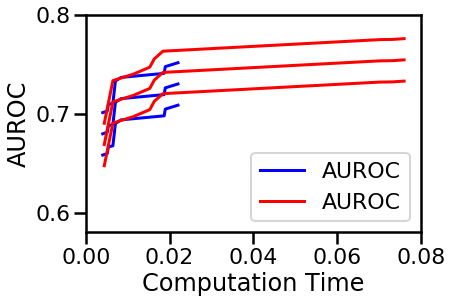

In [216]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TB']).transpose().dropna().values,time=TB.index)
# sns.tsplot(pd.DataFrame(full_dict['TB']).transpose().dropna().values,time=TB_full.index,color='r')
data = TM; data_name = 'TM'
ax = data.plot(x='Computation Time',y='AUROC',color='b')
sns.lineplot(y=data.AUROC+(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
sns.lineplot(y=data.AUROC-(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
data = TM_full
data.plot(x='Computation Time',y='AUROC',color='r',ax=ax)
sns.lineplot(y=data.AUROC+(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')
sns.lineplot(y=data.AUROC-(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')


# TB.iloc[:7].plot(color='g');TB.iloc[5:].plot(color='k')
# TB_full.iloc[:-2].plot(color='g');TB_full.iloc[-3:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('Images\\Features_TremorMulti.svg')

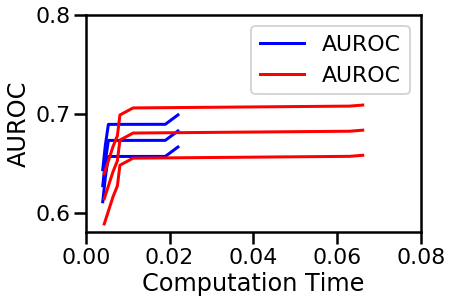

In [217]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TB']).transpose().dropna().values,time=TB.index)
# sns.tsplot(pd.DataFrame(full_dict['TB']).transpose().dropna().values,time=TB_full.index,color='r')
data = BB; data_name = 'BB'
ax = data.plot(x='Computation Time',y='AUROC',color='b')
sns.lineplot(y=data.AUROC+(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
sns.lineplot(y=data.AUROC-(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
data = BB_full
data.plot(x='Computation Time',y='AUROC',color='r',ax=ax)
sns.lineplot(y=data.AUROC+(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')
sns.lineplot(y=data.AUROC-(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')


# TB.iloc[:7].plot(color='g');TB.iloc[5:].plot(color='k')
# TB_full.iloc[:-2].plot(color='g');TB_full.iloc[-3:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('Images\\Features_BradyBinary.svg')

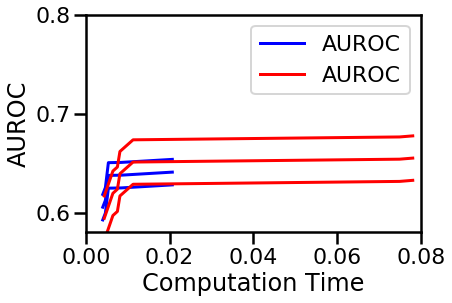

In [218]:
# ax = sns.tsplot(pd.DataFrame(mag_dict['TB']).transpose().dropna().values,time=TB.index)
# sns.tsplot(pd.DataFrame(full_dict['TB']).transpose().dropna().values,time=TB_full.index,color='r')
data = BM; data_name = 'BM'
ax = data.plot(x='Computation Time',y='AUROC',color='b')
sns.lineplot(y=data.AUROC+(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
sns.lineplot(y=data.AUROC-(1.96*mag_sem[data_name]),x=data['Computation Time'],color='b')
data = BM_full
data.plot(x='Computation Time',y='AUROC',color='r',ax=ax)
sns.lineplot(y=data.AUROC+(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')
sns.lineplot(y=data.AUROC-(1.96*full_sem[data_name]),x=data['Computation Time'],color='r')


# TB.iloc[:7].plot(color='g');TB.iloc[5:].plot(color='k')
# TB_full.iloc[:-2].plot(color='g');TB_full.iloc[-3:].plot(color='k')
plt.ylim([.58,.8])
plt.xlim([0,.08])
ax.set_xlabel('Computation Time')
ax.set_ylabel('AUROC')
plt.savefig('Images\\Features_BradyMulti.svg')

In [294]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[col])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

def HBCorrections(df,comps,target=.05):
    res = []
    for pair in comps:
        p = PairedT(df[pair[0]].values, df[pair[1]].values)[1]/2
        res.append((p,str(pair[0])+'+'+str(pair[1])))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<2*thresh:
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s%.3f\t%.3f\t%s'%(r[1]+' '*(13-len(r[1])),r[0]/2,thresh,dec))

In [ ]:
groups = results['sensor']['Tremor']['Binary']['res_all']['Combination'].values

In [ ]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in TB.index]).transpose(), 
                 columns = TB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

In [ ]:
D

In [ ]:
HBCorrections(D,[('ftej','j'),('ftej','cj'),('ftej','tj'),('ftej','fj'),('ftej','te'),('ftej','ecj'),('ftej','tej')])

In [ ]:
TB

In [ ]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in TM.index]).transpose(), 
                 columns = TM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

In [ ]:
D

In [ ]:
HBCorrections(D,[('ftej','j'),('ftej','cj'),('ftej','tj'),('ftej','fj'),('ftej','ecj'),('ftej','tej'),('ftej','fej')])

In [ ]:
TM

In [ ]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Binary']['res_groups'][g]['Random Forest']['auroc']
                                   for g in BB.index]).transpose(), 
                 columns = BB.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

In [ ]:
D

In [ ]:
HBCorrections(D,[('ftj','j'),('ftj','t'),('ftj','tj')])

In [ ]:
BB

In [ ]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Multiclass']['res_groups'][g]['Random Forest']['RMS']
                                   for g in BM.index]).transpose(), 
                 columns = BM.index)
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

In [ ]:
D

In [ ]:
HBCorrections(D,[('tej','j'),('tej','t'),('tej','tj'),('tej','fj'),
                 ('tej','ftj')])

In [ ]:
BM